# CAP 5610 Term Project
## Automating Classification of Galxies, Stars, and Quasars
#### Jaden Huelle
#### 4/08/2025
#### Dr. Mengxin Zheng
#### CAP 5610 - Machine Learning

In [2]:
# Import statemnts
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load in data
data = pd.read_csv('./data/star_classification.csv')

# Print original data shape and distibution
print("Initial data shape:", data.shape)
print("Original Distribution", data['class'].value_counts())


Initial data shape: (100000, 18)
Original Distribution class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64


In [4]:
# Make classes numerical instead of strings
data['class'] = data['class'].map({'GALAXY': 0, 'QSO': 1, 'STAR': 2})
data['class']

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: class, Length: 100000, dtype: int64

In [5]:
def class_distribution_chart(data, title):
    # Get class distribution
    class_counts = data['class'].value_counts()

    # Map numeric labels back to original class names
    class_names = {0: 'GALAXY', 1: 'QSO', 2: 'STAR'}

    # Create pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(class_counts, 
            labels=[class_names[i] for i in class_counts.index],
            autopct='%1.1f%%',
            startangle=90,
            colors=['#ff9999','#66b3ff','#99ff99'])

    # Add title
    plt.title(title)

    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')

    plt.show()

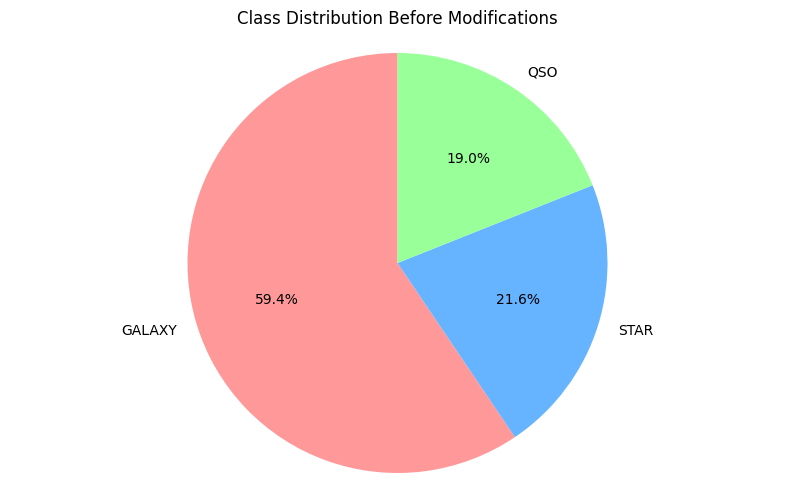

In [15]:
# Show class distribution before dataset modifications
class_distribution_chart(data, "Class Distribution Before Modifications")

In [16]:
# Function for adding three new features to dataset
def add_features(data):
    # Checks if redshift column is greater than 1
    data['redshift_threshold'] = (data['redshift'] > 1.0).astype(int)
    
    # Averages the sensor data
    data['avg_sensor'] = data[['u', 'g', 'r', 'i', 'z']].mean(axis=1)
    
    # Range of sensor data
    data['spectral_range'] = data[['u', 'g', 'r', 'i', 'z']].max(axis=1) - data[['u', 'g', 'r', 'i', 'z']].min(axis=1)
    
    return data

data = add_features(data)

In [17]:
# Separate input data from labels
input_data = data.drop(['class'], axis=1)
labels = data['class']

# Split data between testing and training data (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    input_data, labels, test_size=0.2, random_state=42
)

In [18]:
# Use oversampling to balance classes
balanced_data = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = balanced_data.fit_resample(X_train, y_train)

In [19]:
# Normalize training and testing data
normalized_data = StandardScaler()
normalized_data.fit(X_train_resampled)

X_train_scaled = normalized_data.transform(X_train_resampled)
X_test_scaled = normalized_data.transform(X_test)  

In [20]:
# Initialize dataframes for model
tr_input_data = pd.DataFrame(X_train_scaled, columns=input_data.columns)
tes_input_data = pd.DataFrame(X_test_scaled, columns=input_data.columns)

tr_labels = y_train_resampled
tes_labels = y_test

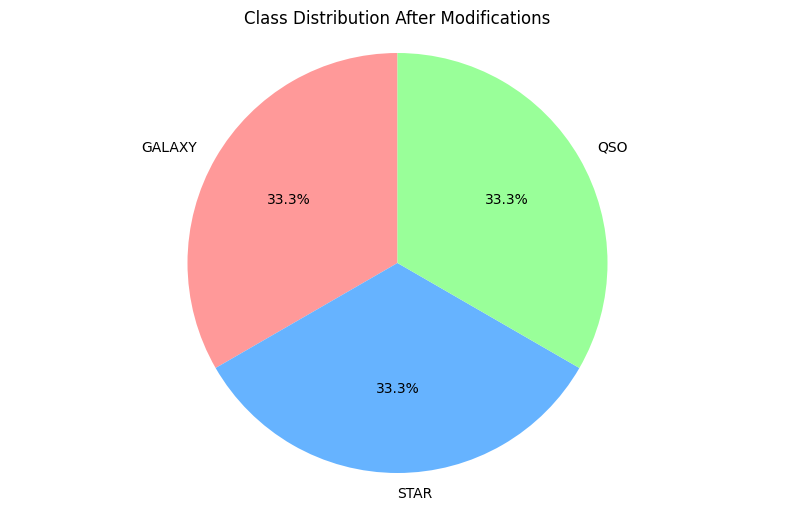

In [21]:
# Show class distribution after dataset modifications
tr_labels_df = pd.DataFrame({'class': tr_labels})
class_distribution_chart(tr_labels_df, "Class Distribution After Modifications")

In [22]:
# Print shape and distribution after oversampling and normalaizing original dataset
print("Training data shape:", tr_input_data.shape)
print("Test data shape:", tes_input_data.shape)

print("Training class distribution:", pd.Series(tr_labels).value_counts())
print("Test class distribution:", pd.Series(tes_labels).value_counts())


Training data shape: (142755, 20)
Test data shape: (20000, 20)
Training class distribution: class
0    47585
2    47585
1    47585
Name: count, dtype: int64
Test class distribution: class
0    11860
2     4343
1     3797
Name: count, dtype: int64


In [23]:
# Early stopping callback class
class myCallback(tf.keras.callbacks.Callback):
    # Early stopping callback function
    def on_epoch_end(self, epoch, logs={}):
        # Checks if accuraccy has reached 98%
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.98:
            print("\nEarly stopping (98% validation accuracy reached)")
            self.model.stop_training = True

# Function for creating model
def model_structure():
    # Build the model by layers
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation=tf.nn.relu),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(3, activation=tf.nn.softmax)
    ])

    # Compile model with Adam as optimizer and sparse_categorical_crossentropy as loss function
    model.compile(
        optimizer=tf.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [24]:
# Define callback and model structure
callbacks = myCallback()
final_model = model_structure()

# Begin training model
history = final_model.fit(
    tr_input_data, 
    tr_labels,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[callbacks]
)

Epoch 1/10
3569/3569 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8482 - loss: 0.3905 - val_accuracy: 0.9556 - val_loss: 0.1582
Epoch 2/10
3569/3569 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9447 - loss: 0.1633 - val_accuracy: 0.9618 - val_loss: 0.1120
Epoch 3/10
3569/3569 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9501 - loss: 0.1474 - val_accuracy: 0.9451 - val_loss: 0.1509
Epoch 4/10
3569/3569 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9529 - loss: 0.1416 - val_accuracy: 0.9825 - val_loss: 0.0993
Epoch 5/10
3569/3569 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9553 - loss: 0.1366 - val_accuracy: 0.9912 - val_loss: 0.0527
Epoch 6/10
3569/3569 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9545 - loss: 0.1361 - val_accuracy: 0.9995 - val_loss: 0.0253
Epoch 7/10
3569/3569 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9565 - loss: 0.1337 - val_accuracy: 0.9971 - val_loss: 0.0393
Epoch 8/10
3569/3569 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9571 - loss: 0.1306 - 

In [25]:
# Evaluate on training data
train_scores = final_model.evaluate(tr_input_data, tr_labels, verbose=0)
print("\nTraining Metrics:")
print(f"Training Loss: {train_scores[0]:.4f}")
print(f"Training Accuracy: {train_scores[1]:.4f}")

# Evaluate on test data
test_scores = final_model.evaluate(tes_input_data, tes_labels, verbose=0)
print("\nTest Metrics:")
print(f"Test Loss: {test_scores[0]:.4f}")
print(f"Test Accuracy: {test_scores[1]:.4f}")


Training Metrics:
Training Loss: 0.1008
Training Accuracy: 0.9686

Test Metrics:
Test Loss: 0.1161
Test Accuracy: 0.9648


In [26]:
# Make predictions and calculate detailed metrics
y_train_pred = final_model.predict(tr_input_data)
y_test_pred = final_model.predict(tes_input_data)

y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)


4462/4462 ━━━━━━━━━━━━━━━━━━━━ 3s 739us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step


In [27]:
# Print out Precision, Recall, and F1-score for training and testing data
print("Training Set:")
print(f"Precision: {precision_score(tr_labels, y_train_pred_classes, average='weighted'):.4f}")
print(f"Recall: {recall_score(tr_labels, y_train_pred_classes, average='weighted'):.4f}")
print(f"F1-score: {f1_score(tr_labels, y_train_pred_classes, average='weighted'):.4f}")

print("\nTest Set:")
print(f"Precision: {precision_score(tes_labels, y_test_pred_classes, average='weighted'):.4f}")
print(f"Recall: {recall_score(tes_labels, y_test_pred_classes, average='weighted'):.4f}")
print(f"F1-score: {f1_score(tes_labels, y_test_pred_classes, average='weighted'):.4f}")

Training Set:
Precision: 0.9686
Recall: 0.9686
F1-score: 0.9685

Test Set:
Precision: 0.9653
Recall: 0.9648
F1-score: 0.9648


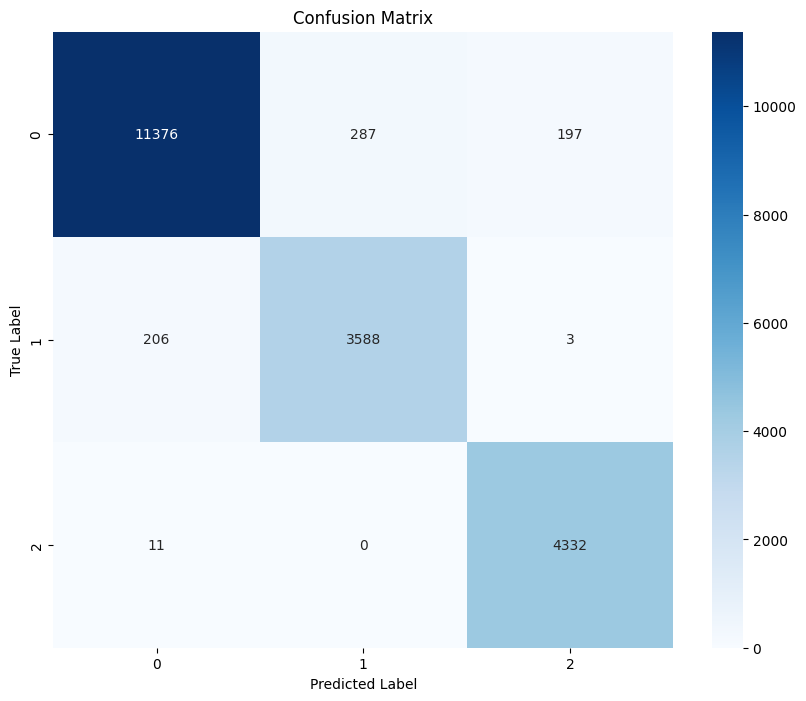

In [28]:
# Create confusion matrix
confusion_matrix = confusion_matrix(tes_labels, y_test_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

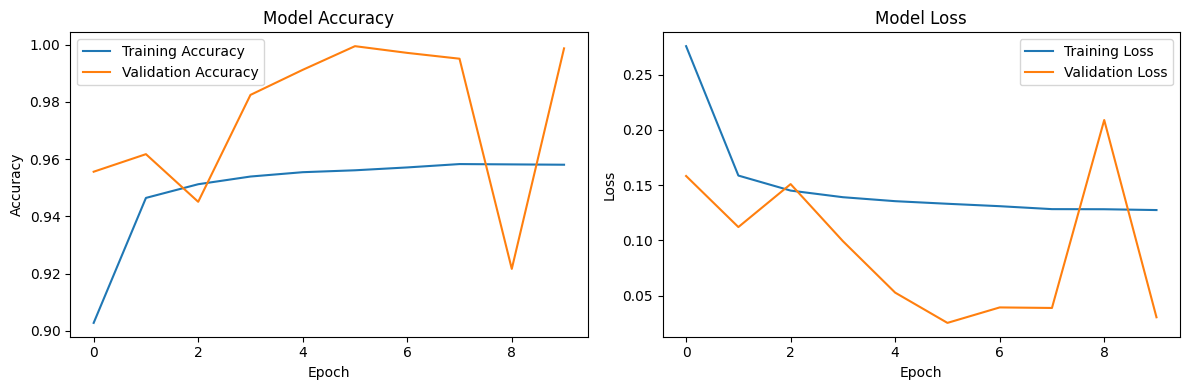

In [29]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()